## Introduction to DAGs, and modeling of causal effects using Julia
In this blog post, I'll introduce the concept of Directed Acyclic Graphs (DAGs) and I'll show how you can use simulation studies to demonstrate that unbiased effects can be estimated by blocking the backdoor paths identified in DAGs.


A DAG is a diagram which demonstrates which things cause other things in a situation of interest. Here, we have a DAG showing the relationship between social factors, smoking, and heart disease. We believe that social factors might cause smoking (for example, people of lower incomes might be more likely to smoke than people of higher incomes). We also believe that social factors might cause heart disease (for example, people who have more money might be able to access more preventative care for heart disease). Finally, we believe that exercise influences risk of heart disease (more exercise lowers your risk for heart disease).

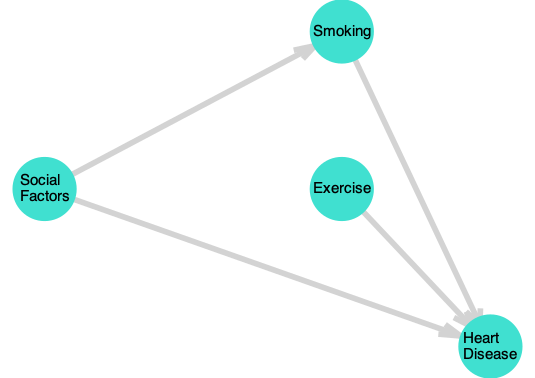

In [186]:
using Graphs, GraphPlot
using Compose, Cairo, Fontconfig

g = SimpleDiGraph(4)
add_edge!(g, 1, 2)
add_edge!(g, 1, 3)
add_edge!(g, 2, 3)
add_edge!(g, 4, 3)
nodelabel = ["Social\nFactors", "Smoking", "Heart\nDisease", "Exercise"]

locs_x = [0, 2, 3, 2]
locs_y = [0, -1, 1, 0]

nodestrokelw = [0, 0, 0, 0, 0]

g = gplot(g, locs_x, locs_y, nodelabel=nodelabel, 
    nodestrokec = "black", nodestrokelw = nodestrokelw, NODESIZE = .15)
draw(PNG("smoking.png", 16cm, 16cm),g)
g

Note that in this DAG, there are no arrows between social factors and exercise (demonstrating that we believe that people of high and low socioeconomic status get the same amount of exercise) and that there are no arrows between smoking and exercise (we do not believe that smokers are more or less likely than non-smokers to exercise). And, note that each connection between components in a DAG only shows a causal effect going one way. The "Acyclic" in DAG means that there can be no cycles, so there can be no path from one component back to itself. 

Also, note that this DAG is just a representation of how we believe the world to be. By creating a DAG, we do not claim that we have the exact correct understanding of which things cause which other things. However, by using a DAG, we clearly present our assumptions, and make it easy for others to see where our assumptions may have been inaccurate.

### A brief introduction to DAGS
When there are two arrows going into a component of a graph, that component is called a collider. Here, L is a collider. 

If a collider is conditioned upon (designated by drawing a circle around the collider), the path between X and Y is open. If a collider is not conditioned upon, the path is closed. 

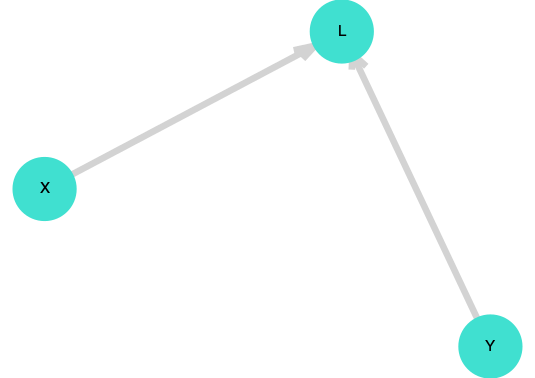

In [217]:
using Graphs, GraphPlot
using Compose, Cairo, Fontconfig

g = SimpleDiGraph(3)
add_edge!(g, 1, 2)
add_edge!(g, 3, 2)

nodelabel = ["X", "L", "Y"]

locs_x = [0, 2, 3]
locs_y = [0, -1, 1]

nodestrokelw = [0, 0, 0]

g = gplot(g, locs_x, locs_y, nodelabel=nodelabel, 
    nodestrokec = "black", nodestrokelw = nodestrokelw, NODESIZE = .15)
draw(PNG("collider_conditioned.png", 16cm, 16cm),g)
g

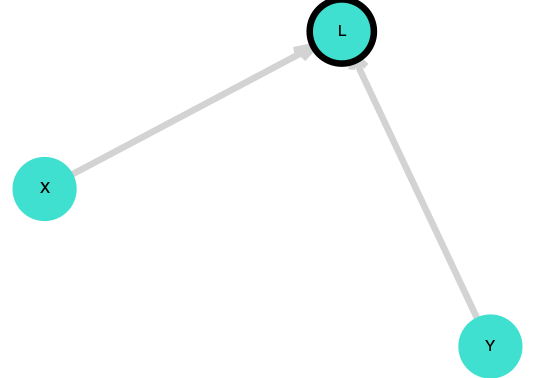

In [219]:
using Graphs, GraphPlot
using Compose, Cairo, Fontconfig

g = SimpleDiGraph(3)
add_edge!(g, 1, 2)
add_edge!(g, 3, 2)

nodelabel = ["X", "L", "Y"]

locs_x = [0, 2, 3]
locs_y = [0, -1, 1]

nodestrokelw = [0, 1, 0]

g = gplot(g, locs_x, locs_y, nodelabel=nodelabel, 
    nodestrokec = "black", nodestrokelw = nodestrokelw, NODESIZE = .15)
draw(PNG("collider_conditioned.png", 16cm, 16cm),g)
g

A component is a non-collider if there is at least one arrow coming out of the component to another component. 

For non-colliders, a path is closed if the component is conditioned upon, and the path is open if the component is not conditioned upon.

In the DAG below, L is a non-collider, and there exists an open path between X and Y. 

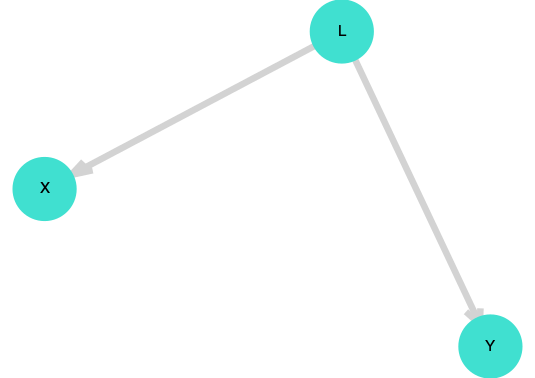

In [188]:
using Graphs, GraphPlot
using Compose, Cairo, Fontconfig

g = SimpleDiGraph(3)
add_edge!(g, 2, 1)
add_edge!(g, 2, 3)

nodelabel = ["X", "L", "Y"]

locs_x = [0, 2, 3]
locs_y = [0, -1, 1]

nodestrokelw = [0, 0, 0]

g = gplot(g, locs_x, locs_y, nodelabel=nodelabel, 
    nodestrokec = "black", nodestrokelw = nodestrokelw, NODESIZE = .15)
draw(PNG("non_collider.png", 16cm, 16cm),g)
g

### The backdoor criterion

One way in which estimates of causal effects may be biased is if there is an open backdoor path between the independent variable and the dependent variable. A path is a backdoor path if it has an arrow coming into (rather than out of) the independent variable.

We can condition upon a component in our graph in many ways. In this post, I will condition on a component by including it as a covariate in a linear model and by restricting our analytical population based on the component. I will signify that a component is conditioned upon by drawing a circle around the component. 

A path between two variables is blocked if it contains a non-collider that has been conditioned upon, or if it has a collider which has not been conditioned upon. (To be precise, none of the descendants of the collider can be conditioned on either for a path to be blocked)

Here, a backdoor path between X and Y is open because there are only non-colliders between X and Y, and because none of these non-colliders have been conditioned upon. If we were to estimate an effect of X on Y without including any other covariate, the effect would be biased. 

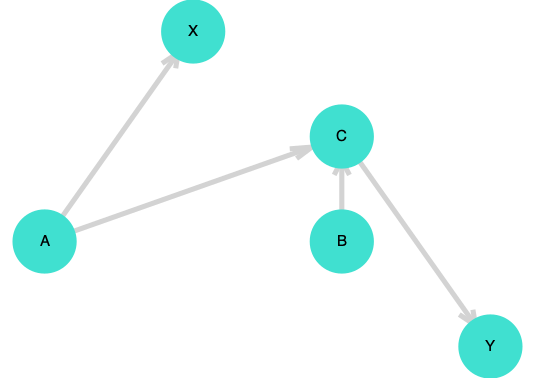

In [189]:
using Graphs, GraphPlot

g = SimpleDiGraph(5)
add_edge!(g, 1, 2)

add_edge!(g, 2, 3)
add_edge!(g, 1, 4)
add_edge!(g, 5, 2)
nodelabel = ["A", "C", "Y", "X", "B"]

locs_x = [0, 2, 3, 1, 2]
locs_y = [0, -1, 1, -2, 0]

nodestrokelw = [0, 0, 0, 0, 0]


g = gplot(g, locs_x, locs_y, nodelabel=nodelabel, 
    nodestrokec = "black", nodestrokelw = nodestrokelw, NODESIZE = .15)

draw(PNG("open_path.png", 16cm, 16cm),g)
g

Here, the path is closed because we conditioned on C

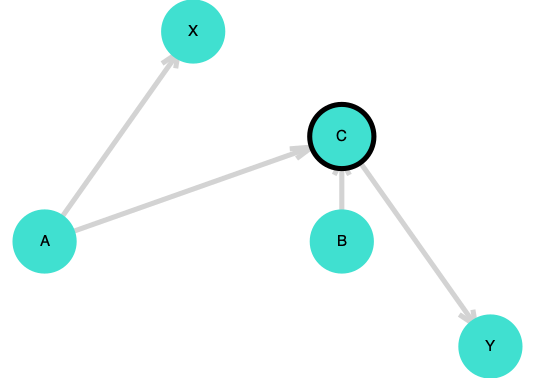

In [190]:
using Graphs, GraphPlot

g = SimpleDiGraph(5)
add_edge!(g, 1, 2)

add_edge!(g, 2, 3)
add_edge!(g, 1, 4)
add_edge!(g, 5, 2)
nodelabel = ["A", "C", "Y", "X", "B"]

locs_x = [0, 2, 3, 1, 2]
locs_y = [0, -1, 1, -2, 0]

nodestrokelw = [0, 1, 0, 0, 0]


g = gplot(g, locs_x, locs_y, nodelabel=nodelabel, 
    nodestrokec = "black", nodestrokelw = nodestrokelw, NODESIZE = .15)

draw(PNG("closed_path.png", 16cm, 16cm),g)
g

### The basics of Julia

Julia is a programming language which is designed for statisticians and data scientists. I won't attempt to explain everything about using Julia in this post, but there are a few commands that you should be familiar with:

In [191]:
using DataFrames, GLM 

x = rand(10)  #creates 10 random numbers between 0 and 1
y = x .+ 5 # adds 5 to each of the random numbers that have been created. So, these numbers will be between 5 and 6.
# The . in .+ means that we are adding 5 to each element of x
# if we were adding 2 vectors together or 2 scalars together we would just use +
z = rand(Normal(0, 1), 10) #samples 10 numbers from a normal distribution with mean 0 and standard deviation 1


df = DataFrame(z = z, y = y) #create a dataframe with columns for z and y
lm(@formula(y ~ z), df) # fit a linear model with y as the dependent variable and z as the independent variable


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

y ~ 1 + z

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  5.52486     0.107426   51.43    <1e-10   5.27714    5.77259
z            0.0261243   0.0831303   0.31    0.7614  -0.165575   0.217823
─────────────────────────────────────────────────────────────────────────

Now, we can start simulating some data. We'll start by by considering a situation which can be represented using this DAG:

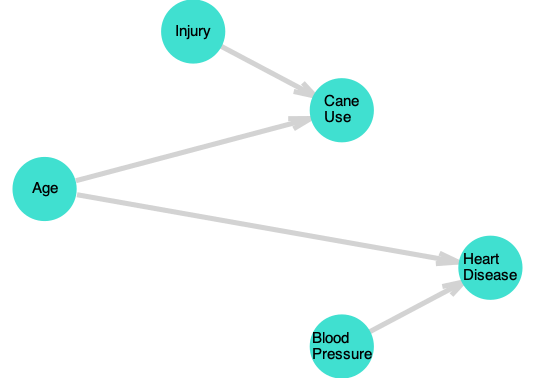

In [220]:
using Graphs, GraphPlot

g = SimpleDiGraph(5)
add_edge!(g, 1, 2)
add_edge!(g, 1, 3)
add_edge!(g, 4, 2)
add_edge!(g, 5, 3)
nodelabel = ["Age", "Cane\nUse", "Heart\nDisease", "Injury", "Blood\nPressure"]

locs_x = [0, 2, 3, 1, 2]
locs_y = [0, -1, 1, -2, 2]

nodestrokelw = [0, 0, 0, 0, 0]


g = gplot(g, locs_x, locs_y, nodelabel=nodelabel, 
    nodestrokec = "black", nodestrokelw = nodestrokelw, NODESIZE = .15)

draw(PNG("heart_disease_1.png", 16cm, 16cm),g)
g

First, let's generate plausible values for age, injury, and smoking. These variables don't have any arrows going into them, so we assume that they are just generated according to a random process. Note that this simulation is deliberately simplistic and not representative of real-life data. 

In [221]:
using Distributions
n = 1000


blood_pressure = rand(Normal(80, 10), n) # reasonable range of numbers for blood pressure
injury = rand(Bernoulli(0.1), n) # 10% of our population has a leg injury
age = rand(n) * 100 #We'll assume that our population is uniformly distributed between 0 and 100

1000-element Vector{Float64}:
 95.5475455002515
 39.09850072823843
 72.61833493194055
 66.88615588110834
 97.92251564730009
 12.784685558460652
 89.81913074308488
 61.99059200438847
 50.78945063451321
 55.26094628917575
  5.714049149347988
 77.61365829929339
 88.53145108078839
  ⋮
 25.822384380807495
 14.293630831848436
 54.914668706440025
 13.215324676245977
 50.57609277364288
 79.63042537988933
 54.54427785677364
 39.54023252070568
 13.723531270586875
 25.050717261766607
 18.05422979833491
 28.693898067449975

Now, we'll generate heart disease and cane use, which will not be independent. 

For cane use, we'll assume that having an injury is like adding 40 years to your life. And, we'll say that anyone with an injury-adjusted "age" over 80 will use a cane. 

In [222]:
cane_use_score = age+injury*40
cane_use= cane_use_score .> 80

1000-element BitVector:
 1
 0
 0
 0
 1
 0
 1
 0
 0
 0
 0
 1
 1
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [223]:
heart_disease_score = age+blood_pressure
heart_disease= heart_disease_score.>120

1000-element BitVector:
 1
 1
 1
 1
 1
 0
 1
 1
 1
 1
 0
 1
 1
 ⋮
 0
 0
 1
 0
 1
 1
 1
 1
 0
 0
 0
 0

In [224]:
using DataFrames
df = DataFrame(blood_pressure = blood_pressure, age = age, injury=injury, cane_use = cane_use, heart_disease = heart_disease)

Row,blood_pressure,age,injury,cane_use,heart_disease
,Float64,Float64,Bool,Bool,Bool
1,82.2344,95.5475,false,true,true
2,83.6065,39.0985,true,false,true
3,101.954,72.6183,false,false,true
4,72.4859,66.8862,false,false,true
5,96.8344,97.9225,false,true,true
6,85.8202,12.7847,false,false,false
7,58.0495,89.8191,false,true,true
8,83.8912,61.9906,false,false,true
9,79.26,50.7895,false,false,true


If we only include cane use in this model, we leave an open backdoor path. If we fit a logistic regression model that leaves the backdoor path open, we will have a biased estimate. 

The true effect of cane use on heart disease is zero because cane use was not used in our generating process for heart disease. Thus, if the coefficient for cane use is non-zero, we know that the estimate was biased. 

In [225]:
using GLM
unadjusted_model = glm(@formula(heart_disease ~ cane_use), df, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

heart_disease ~ 1 + cane_use

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      z  Pr(>|z|)  Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  -0.190157    0.073409  -2.59    0.0096  -0.334036  -0.0462781
cane_use      4.08605     0.457633   8.93    <1e-18   3.18911    4.983
──────────────────────────────────────────────────────────────────────────

Now, let's close the backdoor path in this model by adjusting for age. 

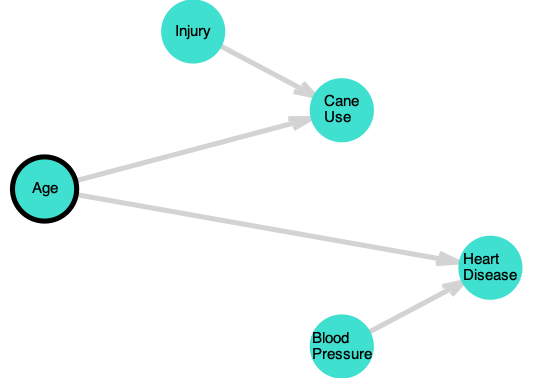

In [226]:
using Graphs, GraphPlot

g = SimpleDiGraph(5)
add_edge!(g, 1, 2)
add_edge!(g, 1, 3)
add_edge!(g, 4, 2)
add_edge!(g, 5, 3)
nodelabel = ["Age", "Cane\nUse", "Heart\nDisease", "Injury", "Blood\nPressure"]

locs_x = [0, 2, 3, 1, 2]
locs_y = [0, -1, 1, -2, 2]

nodestrokelw = [1, 0, 0, 0, 0]


g = gplot(g, locs_x, locs_y, nodelabel=nodelabel, 
    nodestrokec = "black", nodestrokelw = nodestrokelw, NODESIZE = .15)

draw(PNG("heart_disease_blocked.png", 16cm, 16cm),g)
g

In [199]:
adjusted_model = glm(@formula(heart_disease ~ cane_use + age), df, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

heart_disease ~ 1 + cane_use + age

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error       z  Pr(>|z|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  -7.9067     0.628814   -12.57    <1e-35  -9.13915   -6.67425
cane_use      0.170928   0.60365      0.28    0.7771  -1.01221    1.35406
age           0.195755   0.0151852   12.89    <1e-37   0.165993   0.225518
──────────────────────────────────────────────────────────────────────────

After adjusting for the confounder, cane use is no longer associated with heart disease. 

Let's take a look at selection bias. 

Here, we'll do a study to see if there is a relationship between age and height. But, because of funding limitations, we can only recruit for our study at an amusement park. We decide to set up our station in the exit doors of a roller coaster. However, the roller coaster requires that individuals be at least 9 years old and at least 150 cm to ride the coaster. 

First, let's generate some data assuming that each year, a child grows 5 cm each year.

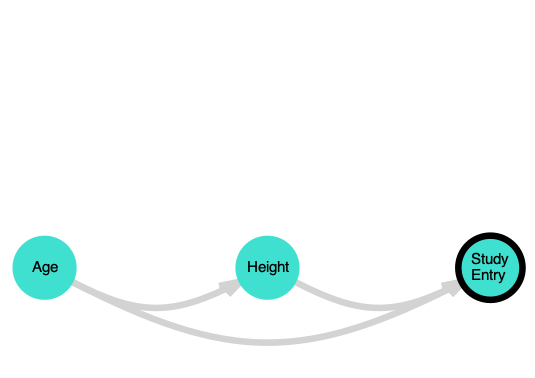

In [200]:
using Graphs, GraphPlot

g = SimpleDiGraph(3)
add_edge!(g, 1, 2)
add_edge!(g, 3, 2)
add_edge!(g, 1, 3)

nodelabel = ["Age", "Study\nEntry",  "Height"]
nodestrokelw = [0, 1, 0]

locs_x = [-10, 10, 0]
locs_y = [1, 1, 1]
gplot(g, locs_x, locs_y, nodelabel=nodelabel, 
    nodestrokec = "black", nodestrokelw = nodestrokelw, NODESIZE = .15,
linetype = "curve"
)

In [201]:
n = 10000000
height = rand(Normal(130, 10), n) # reasonable range of numbers for blood pressure
age = rand(n) * 18 #We'll assume that only young people like going to theme parks
df = DataFrame(age = age, height = height)

df.s1 = df.age + rand(n) * 10 .+ 1
df.s2 = df.height + rand(Normal(130, 10), n)

df.height = df.height + df.age .*5 .- mean(df.age) .*5

#df.selection = df.age .* 10 + df.height

# selected_df = df[df.selection .> 150, :]

# selected_df = df[(df.s1 .> 16) .* (df.s2 .> 300),:]

selected_df = df[(df.age .> 9) .* (df.height .> 150),:]

Row,age,height,s1,s2
,Float64,Float64,Float64,Float64
1,17.0541,175.655,20.8465,257.112
2,16.5332,160.918,20.9036,251.888
3,12.3873,152.044,13.9825,283.161
4,15.9702,168.935,18.8487,254.881
5,15.2372,160.114,24.961,273.027
6,15.0534,159.863,16.2586,269.309
7,15.2702,160.111,16.8619,279.468
8,17.2811,185.948,28.2744,287.764
9,15.9768,160.974,20.6425,248.793


Now, let's verify that the true relationship could have been recovered had no selection effects ever happened. This is what our sample would have been like if we had taken a random sample of children and asked them their ages and height. 

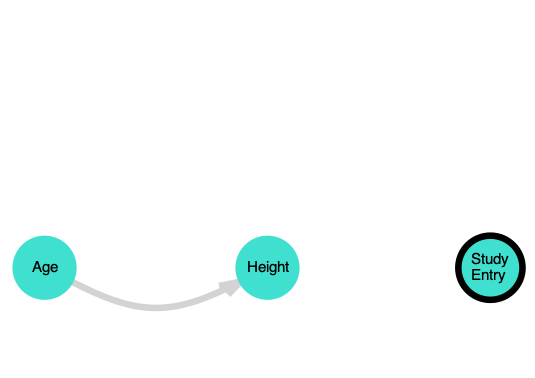

In [202]:
using Graphs, GraphPlot

g = SimpleDiGraph(3)
#add_edge!(g, 1, 2)
#add_edge!(g, 3, 2)
add_edge!(g, 1, 3)

nodelabel = ["Age", "Study\nEntry",  "Height"]
nodestrokelw = [0, 1, 0]

locs_x = [-10, 10, 0]
locs_y = [1, 1, 1]
gplot(g, locs_x, locs_y, nodelabel=nodelabel, 
    nodestrokec = "black", nodestrokelw = nodestrokelw, NODESIZE = .15,
linetype = "curve"
)

In [203]:
using GLM
model_no_selection = lm(@formula(height ~ age), df)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

height ~ 1 + age

Coefficients:
────────────────────────────────────────────────────────────────────────────
                Coef.   Std. Error         t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  85.0038   0.00632593   13437.36    <1e-99   84.9914    85.0161
age           4.99935  0.000608695   8213.22    <1e-99    4.99816    5.00054
────────────────────────────────────────────────────────────────────────────

And, now, we'll show that if we use data that are collected with selection effects, our estimate for how much someone grows per year of age is biased. 

In [204]:
using GLM
model_selection = lm(@formula(height ~ age), selected_df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

height ~ 1 + age

Coefficients:
───────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error        t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)  120.835     0.0384283  3144.42    <1e-99  120.76     120.91
age            2.88792   0.0025198  1146.09    <1e-99    2.88298    2.89286
───────────────────────────────────────────────────────────────────────────

One kind of bias that can be seen in causal inference is M-bias. In M-bias, an open backdoor path can exist despite there being no "common cause" of the independent and dependent variables. 

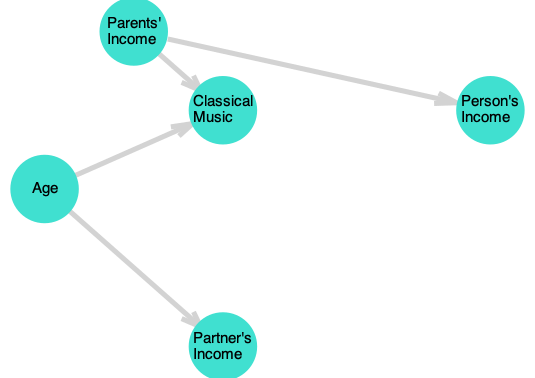

In [205]:
using Graphs, GraphPlot

g = SimpleDiGraph(5)
add_edge!(g, 1, 2)
add_edge!(g, 1, 5)
add_edge!(g, 4, 2)
add_edge!(g, 4, 3)
#add_edge!(g, 5, 3)
nodelabel = ["Age", "Classical\nMusic", "Person's\nIncome", "Parents'\nIncome", "Partner's\nIncome"]

locs_x = [0, 2, 5, 1, 2]
locs_y = [0, -1, -1, -2, 2]

nodestrokelw = [0, 0, 0, 0, 0]


p = gplot(g, locs_x, locs_y, nodelabel=nodelabel, 
    nodestrokec = "black", nodestrokelw = nodestrokelw, NODESIZE = .16)

draw(PNG("m_bias_1.png", 16cm, 16cm),p)
p

In [206]:
n = 1000
age = rand(n) .* 50 .+ 20 #We'll look at people with ages 20 to 70. 
parents_income = rand(Normal(50000, 20000), n) #income is definitely not normally distributed, but we'll use it in this example

# We'll assume everyone has some chance of being really interested in classical music
musical_interest = rand(Bernoulli(0.3), n) .* 2 

# We'll assume that parents with higher income will always have their kids listen to more classical music 
# (1 additional minute of music per 100 dollars of income) and that people who are older listen to more 
# classical music (10 additional minutes per year of age)
minutes_per_year = musical_interest .* 30 + parents_income ./ 100 + age .* 10

# We'll assume that on average, people make 1000 additional dollars per year they work. 
# And, we'll assume that everyone has an average baseline pay of 20,000 per year
partner_income = rand(Normal(20000, 10000), n) + age .* 1000

# We'll assume that a person's income is related to their parents' income, and that people vary 
# from their parents' income by about $10,000 on average. 
personal_income = parents_income + rand(Normal(0, 10000), n)


df = DataFrame(age = age, parents_income = parents_income, 
    minutes_per_year = minutes_per_year, partner_income = partner_income,
personal_income = personal_income)


Row,age,parents_income,minutes_per_year,partner_income,personal_income
,Float64,Float64,Float64,Float64,Float64
1,57.0652,57956.1,1150.21,72928.2,74050.5
2,36.6963,58573.7,1012.7,55895.0,49094.5
3,29.2702,28245.3,635.156,40494.0,21516.1
4,28.8949,45665.1,805.6,37504.1,39297.1
5,42.3305,54445.9,967.764,66714.3,67895.7
6,32.8528,26189.2,590.42,57313.9,33760.9
7,51.1466,39883.0,970.296,73857.3,39431.7
8,23.6321,42265.4,658.975,39004.6,35678.9
9,54.7624,37756.1,925.185,75212.5,37714.4


In [207]:
using GLM
model = lm(@formula(personal_income ~ partner_income), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

personal_income ~ 1 + partner_income

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────
                        Coef.    Std. Error      t  Pr(>|t|)     Lower 95%       Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────
(Intercept)     54596.2        2711.84       20.13    <1e-75  49274.7       59917.8
partner_income     -0.0711116     0.0401647  -1.77    0.0769     -0.149928      0.00770525
──────────────────────────────────────────────────────────────────────────────────────────

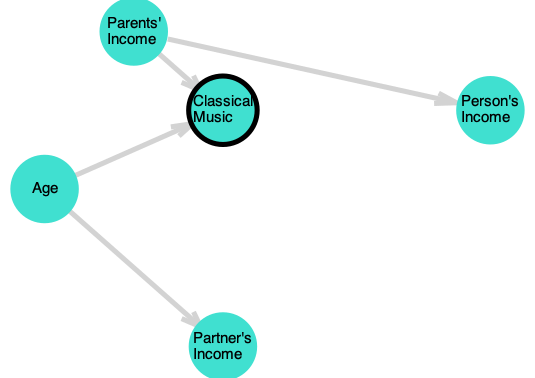

In [208]:
using Graphs, GraphPlot

g = SimpleDiGraph(5)
add_edge!(g, 1, 2)
add_edge!(g, 1, 5)
add_edge!(g, 4, 2)
add_edge!(g, 4, 3)
#add_edge!(g, 5, 3)
nodelabel = ["Age", "Classical\nMusic", "Person's\nIncome", "Parents'\nIncome", "Partner's\nIncome"]

locs_x = [0, 2, 5, 1, 2]
locs_y = [0, -1, -1, -2, 2]

nodestrokelw = [0, 1, 0, 0, 0]


p = gplot(g, locs_x, locs_y, nodelabel=nodelabel, 
    nodestrokec = "black", nodestrokelw = nodestrokelw, NODESIZE = .16)

draw(PNG("m_bias_open_path.png", 16cm, 16cm),p)
p

In [209]:
using GLM
model_conditioned = lm(@formula(personal_income ~ partner_income + minutes_per_year), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

personal_income ~ 1 + partner_income + minutes_per_year

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                        Coef.    Std. Error       t  Pr(>|t|)    Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)       7992.43      1924.05         4.15    <1e-04  4216.78      11768.1
partner_income      -0.581704     0.0264102  -22.03    <1e-87    -0.633529     -0.529878
minutes_per_year    82.5458       1.90231     43.39    <1e-99    78.8128       86.2788
────────────────────────────────────────────────────────────────────────────────────────

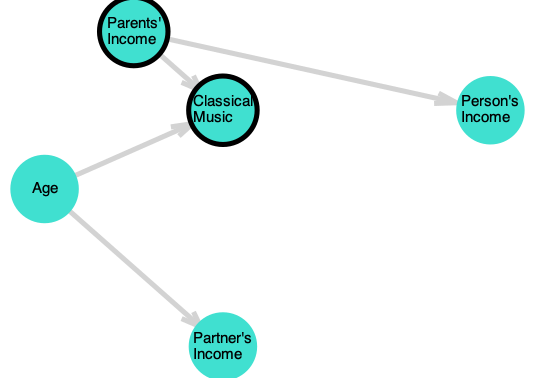

In [210]:
using Graphs, GraphPlot

g = SimpleDiGraph(5)
add_edge!(g, 1, 2)
add_edge!(g, 1, 5)
add_edge!(g, 4, 2)
add_edge!(g, 4, 3)
#add_edge!(g, 5, 3)
nodelabel = ["Age", "Classical\nMusic", "Person's\nIncome", "Parents'\nIncome", "Partner's\nIncome"]

locs_x = [0, 2, 5, 1, 2]
locs_y = [0, -1, -1, -2, 2]

nodestrokelw = [0, 1, 0, 1, 0]


p = gplot(g, locs_x, locs_y, nodelabel=nodelabel, 
    nodestrokec = "black", nodestrokelw = nodestrokelw, NODESIZE = .16)

draw(PNG("m_bias_2_conditions.png", 16cm, 16cm),p)
p

In [211]:
using GLM
model_conditioned_backdoor_blocked = lm(@formula(personal_income ~ partner_income + parents_income + minutes_per_year), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

personal_income ~ 1 + partner_income + parents_income + minutes_per_year

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                         Coef.    Std. Error      t  Pr(>|t|)    Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)       2709.85       1566.75        1.73    0.0840  -364.652     5784.35
partner_income      -0.0433236     0.0314577  -1.38    0.1688    -0.105055     0.0184074
parents_income       0.964769      0.0415196  23.24    <1e-95     0.883293     1.04625
minutes_per_year     1.82847       3.79682     0.48    0.6302    -5.62222      9.27916
────────────────────────────────────────────────────────────────────────────────────────

Now, what would happen if there was an effect of partner income on personal income? (For example, maybe a high-earning partner might help get you a job at their high-paying company)

In [212]:
personal_income = parents_income + rand(Normal(0, 10000), n) + partner_income .- mean(partner_income)


df = DataFrame(age = age, parents_income = parents_income, 
    minutes_per_year = minutes_per_year, partner_income = partner_income,
personal_income = personal_income)

Row,age,parents_income,minutes_per_year,partner_income,personal_income
,Float64,Float64,Float64,Float64,Float64
1,57.0652,57956.1,1150.21,72928.2,61123.6
2,36.6963,58573.7,1012.7,55895.0,50363.6
3,29.2702,28245.3,635.156,40494.0,-4540.68
4,28.8949,45665.1,805.6,37504.1,19192.8
5,42.3305,54445.9,967.764,66714.3,63425.0
6,32.8528,26189.2,590.42,57313.9,5268.72
7,51.1466,39883.0,970.296,73857.3,25462.2
8,23.6321,42265.4,658.975,39004.6,19147.9
9,54.7624,37756.1,925.185,75212.5,54739.8


We still get the correct effect (in this case, 1) by not conditioning on the minutes of classical music per year. 

In [213]:
using GLM
model = lm(@formula(personal_income ~ partner_income), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

personal_income ~ 1 + partner_income

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────
                        Coef.   Std. Error      t  Pr(>|t|)     Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────────────
(Intercept)     -11324.3       2806.52      -4.03    <1e-04  -16831.6      -5816.91
partner_income       0.942698     0.041567  22.68    <1e-91       0.86113      1.02427
──────────────────────────────────────────────────────────────────────────────────────

In [214]:
using GLM
model_conditioned = lm(@formula(personal_income ~ partner_income + minutes_per_year), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

personal_income ~ 1 + partner_income + minutes_per_year

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────
                          Coef.    Std. Error       t  Pr(>|t|)      Lower 95%      Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)       -60272.4       1934.07       -31.16    <1e-99  -64067.7       -56477.1
partner_income         0.406422     0.0265477   15.31    <1e-46       0.354326       0.458517
minutes_per_year      86.6982       1.91222     45.34    <1e-99      82.9458        90.4506
─────────────────────────────────────────────────────────────────────────────────────────────

In [215]:
using GLM
model_conditioned_backdoor_blocked = lm(@formula(personal_income ~ partner_income + parents_income + minutes_per_year), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

personal_income ~ 1 + partner_income + parents_income + minutes_per_year

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────
                          Coef.    Std. Error       t  Pr(>|t|)      Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)       -65722.8       1551.88       -42.35    <1e-99  -68768.1       -62677.5
partner_income         0.961906     0.0311592   30.87    <1e-99       0.90076        1.02305
parents_income         0.99542      0.0411256   24.20    <1e-99       0.914717       1.07612
minutes_per_year       3.41651      3.76079      0.91    0.3639      -3.96347       10.7965
─────────────────────────────────────────────────────────────────────────

For more information, see [here](https://ftp.cs.ucla.edu/pub/stat_ser/r493.pdf)

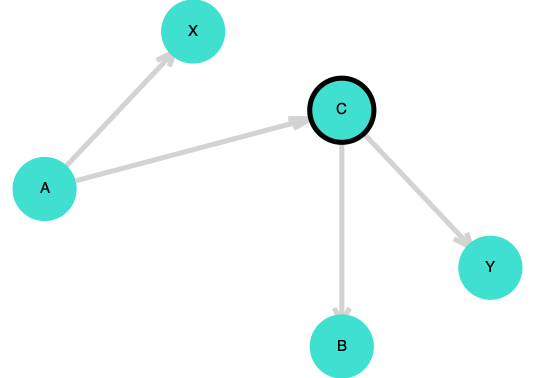

In [216]:
using Graphs, GraphPlot

g = SimpleDiGraph(5)
add_edge!(g, 1, 2)

add_edge!(g, 2, 3)
add_edge!(g, 1, 4)
add_edge!(g, 2, 5)
nodelabel = ["A", "C", "Y", "X", "B"]

locs_x = [0, 2, 3, 1, 2]
locs_y = [0, -1, 1, -2, 2]

nodestrokelw = [0, 1, 0, 0, 0]


g = gplot(g, locs_x, locs_y, nodelabel=nodelabel, 
    nodestrokec = "black", nodestrokelw = nodestrokelw, NODESIZE = .15)

draw(PNG("heart_disease_1.png", 16cm, 16cm),g)
g